In [1]:
# Download detection-engine & utilities from TorchVision’s GitHub
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py          # core train/eval loop :contentReference[oaicite:6]{index=6}
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py           # collate_fn & helpers :contentReference[oaicite:7]{index=7}
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py      # COCO dataset API bridge :contentReference[oaicite:8]{index=8}
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py       # COCO evaluation metrics :contentReference[oaicite:9]{index=9}
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py      # detection-specific transforms :contentReference[oaicite:10]{index=10}

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# 1. Package installations (run as notebook cells, not part of the .py module)
# ----------------------------------------------------------------------------------------------------------------------
!pip install ultralytics
!pip install ensemble_boxes
!pip install torch torchvision pycocotools

# ----------------------------------------------------------------------------------------------------------------------
# 2. Standard library imports
# ----------------------------------------------------------------------------------------------------------------------
import os
import re
import json
import shutil
import warnings
from collections import Counter

warnings.filterwarnings("ignore")

# ----------------------------------------------------------------------------------------------------------------------
# 3. Third-party imports
# ----------------------------------------------------------------------------------------------------------------------
import cv2                                                    # image I/O & drawing
import numpy as np                                            # numerical arrays
import pandas as pd                                           # dataframes
import matplotlib.pyplot as plt                               # plotting
import matplotlib.patches as patches                          # drawing boxes in matplotlib
from PIL import Image                                         # alternative image I/O

import yaml                                                   # configs
import torch                                                  # core PyTorch
from torch.utils.data import Dataset, DataLoader              # dataset & loader API
import torchvision                                            # vision utils & transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F            # tensor conversion

from ultralytics import YOLO                                  # YOLOv8 API
from ensemble_boxes import weighted_boxes_fusion              # ensembling detections

from sklearn.model_selection import StratifiedKFold           # CV splits
from sklearn.preprocessing import LabelEncoder                # label encoding
from tqdm import tqdm                                         # progress bars
import wandb                                                  # experiment tracking

# ----------------------------------------------------------------------------------------------------------------------
# 4. Local/project-specific imports (from torchvision’s GitHub references)
# ----------------------------------------------------------------------------------------------------------------------
from engine import train_one_epoch, evaluate                   # training & evaluation loops
from utils import collate_fn                                   # DataLoader helper
import transforms as T                                         # detection transforms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

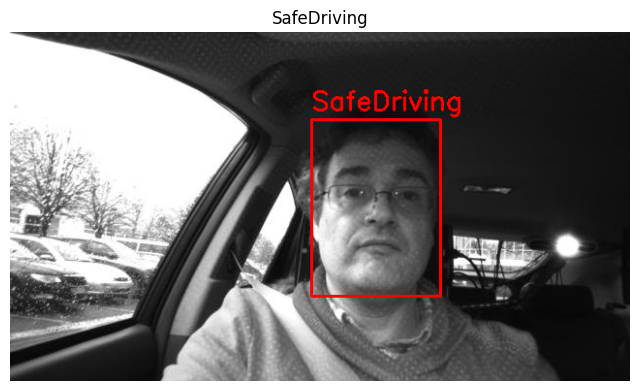

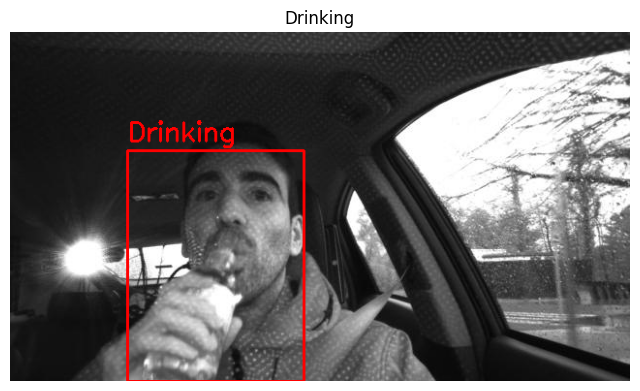

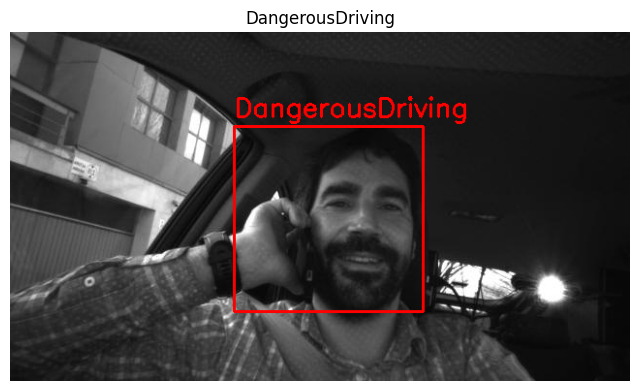

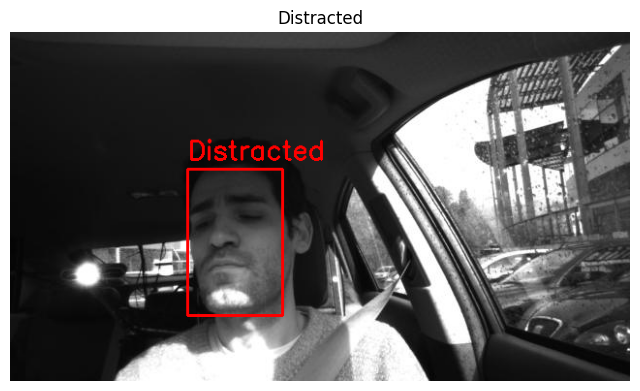

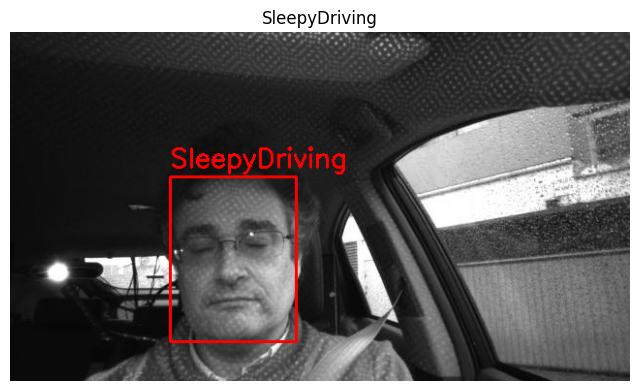

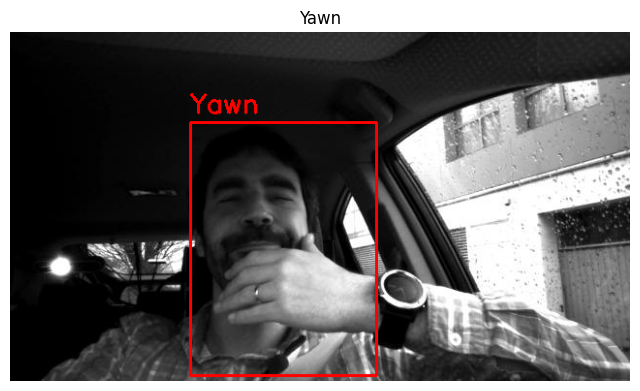

In [3]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random

# Define paths
train_dir = '/kaggle/input/dataset/train/train'
annotations_path = os.path.join(train_dir, '_annotations.txt')  # adjust the name if needed

# Class mapping
class_mapping = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Read annotations
# Read annotations
annotations = []
with open(annotations_path, 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # skip empty lines
        parts = line.split()
        if len(parts) != 2:
            continue  # skip malformed lines
        
        filename = parts[0]
        bbox_class = parts[1].split(',')
        if len(bbox_class) != 5:
            continue  # skip if bbox/class is wrong
        
        x_min, y_min, x_max, y_max, class_id = map(int, bbox_class)
        annotations.append({
            'filename': filename,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'class_id': class_id
        })

df = pd.DataFrame(annotations)

# Visualize random images
def visualize_one_sample_per_class(df):
    sampled_rows = []
    for class_id in df['class_id'].unique():
        class_rows = df[df['class_id'] == class_id]
        if not class_rows.empty:
            sampled_row = class_rows.sample(1).iloc[0]
            sampled_rows.append(sampled_row)

    for row in sampled_rows:
        img_path = os.path.join(train_dir, row['filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding box
        cv2.rectangle(image, (row['x_min'], row['y_min']), (row['x_max'], row['y_max']), (255, 0, 0), 2)

        # Put class label
        label = class_mapping[row['class_id']]
        cv2.putText(image, label, (row['x_min'], row['y_min'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.9, (255, 0, 0), 2)

        # Show image
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)
        plt.show()

# Run visualization
visualize_one_sample_per_class(df)

In [4]:
from torch.utils.data import Dataset
class DrivingDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transforms=None):
        self.images_dir = images_dir
        # Load your parsed annotations DataFrame
        self.df = pd.read_csv(annotations_file)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image
        img_path = os.path.join(self.images_dir, row.filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = F.to_tensor(img)

        # Box & label setup
        boxes = torch.tensor([[row.x_min, row.y_min, row.x_max, row.y_max]], dtype=torch.float32)
        labels = torch.tensor([row.class_id + 1], dtype=torch.int64)  
        # +1 because background=0 in COCO convention

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(
    weights=None,     # no pretrained weights at all
    num_classes=7
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [6]:
import os
import pandas as pd

# 1. Define your directories
train_dir  = '/kaggle/input/dataset/train/train'   # images + _annotations.txt
val_dir    = '/kaggle/input/dataset/valid/valid'       # images + _annotations.txt
output_dir = '/kaggle/working/annotations'
os.makedirs(output_dir, exist_ok=True)

# 2. A helper to read one annotations file into a DataFrame
def read_annotations(ann_path, images_dir):
    records = []
    with open(ann_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 2:
                continue
            filename, bbox_cls = parts
            x_min, y_min, x_max, y_max, class_id = map(int, bbox_cls.split(','))
            # Optionally, verify the image exists:
            img_path = os.path.join(images_dir, filename)
            if not os.path.exists(img_path):
                # skip or warn
                continue
            records.append({
                'filename': filename,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'class_id': class_id
            })
    return pd.DataFrame(records)

# 3. Read train & val annotations
train_ann_txt = os.path.join(train_dir, '_annotations.txt')
val_ann_txt   = os.path.join(val_dir,   '_annotations.txt')

df_train = read_annotations(train_ann_txt, train_dir)
df_val   = read_annotations(val_ann_txt,   val_dir)

# 4. Write out to CSVs
train_csv = os.path.join(output_dir, 'train_annotations.csv')
val_csv   = os.path.join(output_dir,   'val_annotations.csv')

df_train.to_csv(train_csv, index=False)
df_val.to_csv(val_csv,     index=False)

print(f"→ Saved {len(df_train)} rows to {train_csv}")
print(f"→ Saved {len(df_val)}   rows to {val_csv}")

→ Saved 11948 rows to /kaggle/working/annotations/train_annotations.csv
→ Saved 1922   rows to /kaggle/working/annotations/val_annotations.csv


In [ ]:
df=pd.read_csv("/kaggle/working/annotations/train_annotations.csv")
df

In [7]:
import random
import torch
from torchvision.transforms import functional as F

def get_transform(train: bool):
    """
    Returns a function that converts images to tensors and,
    when train=True, randomly flips images and bounding boxes.
    """
    def transform(image, target):
        # 1) Convert to tensor [C, H, W]
        image = F.to_tensor(image)  # converts PIL/ndarray → FloatTensor in [0,1] :contentReference[oaicite:3]{index=3}
        coo=images.shape[1:3]
        # 2) Apply random horizontal flip on training data
        if train and random.random() < 0.5:
            image = F.hflip(image)   # horizontal mirror image :contentReference[oaicite:4]{index=4}
            # Flip bounding boxes: x_min ↔ x_max
            boxes = target["boxes"]
            flipped = boxes.clone()
            width = image.shape[-1]  # tensor shape is [C, H, W]
            flipped[:, [0, 2]] = width - boxes[:, [2, 0]]
            target["boxes"] = flipped

        return image, target

    return transform

# 4. Write out to CSVs (names match later usage)
train_ann_csv = os.path.join(output_dir, 'train_annotations.csv')
val_ann_csv   = os.path.join(output_dir, 'val_annotations.csv')

df_train.to_csv(train_ann_csv, index=False)  # uses train_ann_csv
df_val.to_csv(val_ann_csv,     index=False)  # uses val_ann_csv
train_dataset = DrivingDataset(
    images_dir=train_dir,
    annotations_file=train_ann_csv,
    transforms=get_transform(train=True)
)
val_dataset = DrivingDataset(
    images_dir=val_dir,
    annotations_file=val_ann_csv,
    transforms=get_transform(train=False)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [8]:
# 1. First, let's clean up and use YOLOv8 instead
!pip install ultralytics -q
from ultralytics import YOLO
import os
import shutil
import cv2
import pandas as pd
from tqdm import tqdm

# 2. Define function to load annotations (for train/val only)
def load_annotations(annotations_path, images_dir):
    annotations = []
    with open(annotations_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 2:
                continue
            
            filename = parts[0]
            bbox_class = parts[1].split(',')
            if len(bbox_class) != 5:
                continue
            
            x_min, y_min, x_max, y_max, class_id = map(int, bbox_class)
            annotations.append({
                'filename': filename,
                'x_min': x_min,
                'y_min': y_min,
                'x_max': x_max,
                'y_max': y_max,
                'class_id': class_id
            })
    return pd.DataFrame(annotations)

# 3. Load train and val datasets
train_dir = '/kaggle/input/dataset/train/train'
val_dir = '/kaggle/input/dataset/valid/valid'
test_dir = '/kaggle/input/testset/test'  # No annotations here

df_train = load_annotations(os.path.join(train_dir, '_annotations.txt'), train_dir)
df_val = load_annotations(os.path.join(val_dir, '_annotations.txt'), val_dir)

# 4. Prepare YOLO format dataset with progress bar
def convert_to_yolo_format(df, images_dir, output_dir, has_annotations=True):
    os.makedirs(output_dir, exist_ok=True)
    
    # Create directories
    images_output = os.path.join(output_dir, 'images')
    os.makedirs(images_output, exist_ok=True)
    
    if has_annotations:
        labels_output = os.path.join(output_dir, 'labels')
        os.makedirs(labels_output, exist_ok=True)
    
    # Add progress bar for conversion
    with tqdm(total=len(os.listdir(images_dir)), desc=f"Processing {os.path.basename(output_dir)}") as pbar:
        for img_file in os.listdir(images_dir):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            # Copy image
            img_src = os.path.join(images_dir, img_file)
            img_dst = os.path.join(images_output, img_file)
            shutil.copy(img_src, img_dst)
            
            # Only process annotations if they exist
            if has_annotations:
                # Find matching annotation
                row = df[df['filename'] == img_file]
                if not row.empty:
                    row = row.iloc[0]
                    # Create label file
                    label_file = os.path.join(labels_output, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
                    
                    # Convert to YOLO format
                    img = cv2.imread(img_src)
                    if img is not None:
                        img_h, img_w = img.shape[:2]
                        
                        x_center = (row['x_min'] + row['x_max']) / 2 / img_w
                        y_center = (row['y_min'] + row['y_max']) / 2 / img_h
                        width = (row['x_max'] - row['x_min']) / img_w
                        height = (row['y_max'] - row['y_min']) / img_h
                        
                        with open(label_file, 'w') as f:
                            f.write(f"{row['class_id']} {x_center} {y_center} {width} {height}")
            
            pbar.update(1)

# 5. Convert datasets
print("Converting datasets to YOLO format:")
convert_to_yolo_format(df_train, train_dir, 'yolo_dataset/train', has_annotations=True)
convert_to_yolo_format(df_val, val_dir, 'yolo_dataset/val', has_annotations=True)
convert_to_yolo_format(None, test_dir, 'yolo_dataset/test', has_annotations=False)  # No annotations for test

# 6. Create dataset.yaml
print("\nCreating dataset configuration...")
dataset_yaml = """
path: /kaggle/working/yolo_dataset
train: train/images
val: val/images

names:
  0: DangerousDriving
  1: Distracted
  2: Drinking
  3: SafeDriving
  4: SleepyDriving
  5: Yawn
"""

with open('dataset.yaml', 'w') as f:
    f.write(dataset_yaml)
print("✅ Dataset config created")

# 7. Train YOLOv8 model
print("\nStarting training...")
model = YOLO('yolov8n.pt')  # Load pretrained small model
results = model.train(
    data='dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=8,
    device='0' if torch.cuda.is_available() else 'cpu',
    verbose=True
)

Converting datasets to YOLO format:


Processing test: 100%|██████████| 985/985 [00:07<00:00, 125.23it/s]


Creating dataset configuration...
✅ Dataset config created

Starting training...



100%|██████████| 6.25M/6.25M [00:00<00:00, 79.7MB/s]


Ultralytics 8.3.119 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torch

100%|██████████| 755k/755k [00:00<00:00, 15.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 828.4±281.9 MB/s, size: 25.1 KB)


train: Scanning /kaggle/working/yolo_dataset/train/labels... 11948 images, 18 backgrounds, 0 corrupt: 100%|██████████| 11966/11966 [00:07<00:00, 1547.93it/s]


train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 439.5±217.4 MB/s, size: 23.8 KB)


val: Scanning /kaggle/working/yolo_dataset/val/labels... 1922 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1922/1922 [00:01<00:00, 1308.10it/s]

val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.27G     0.9648      1.632      1.179         11        640: 100%|██████████| 1496/1496 [02:28<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:11<00:00, 10.57it/s]


                   all       1922       1922      0.777      0.833        0.9      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.32G      0.852     0.8145      1.106         11        640: 100%|██████████| 1496/1496 [02:21<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.10it/s]

                   all       1922       1922      0.925      0.855      0.957      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.32G     0.8316     0.6977      1.098         16        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.19it/s]

                   all       1922       1922      0.896      0.902       0.93      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.32G     0.8075     0.6411      1.083         20        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.81it/s]


                   all       1922       1922      0.926      0.926      0.966      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.32G     0.7549     0.5593      1.057         13        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.17it/s]


                   all       1922       1922      0.954      0.933      0.972      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.32G     0.7429     0.5501      1.052         12        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.25it/s]

                   all       1922       1922      0.956      0.922      0.971      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.32G     0.7229     0.5218       1.04         12        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.88it/s]

                   all       1922       1922      0.956      0.941      0.977      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.32G     0.7118     0.5106      1.033         19        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.97it/s]

                   all       1922       1922      0.942      0.939      0.964      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.32G     0.7052      0.494      1.033         14        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.17it/s]

                   all       1922       1922      0.951       0.95      0.979      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.32G     0.6951     0.4846      1.026         13        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.02it/s]

                   all       1922       1922      0.967      0.947      0.975      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.32G     0.6818      0.472      1.019         11        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.84it/s]

                   all       1922       1922      0.937       0.95      0.974      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.32G     0.6686     0.4555      1.013         14        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.17it/s]

                   all       1922       1922      0.961      0.945      0.976      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.32G     0.6658     0.4491      1.014         12        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.34it/s]

                   all       1922       1922      0.951      0.953      0.975      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.32G     0.6634     0.4448       1.01          9        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.95it/s]

                   all       1922       1922      0.953      0.945      0.976      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.32G     0.6498      0.437      1.005         13        640: 100%|██████████| 1496/1496 [02:20<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.17it/s]

                   all       1922       1922       0.96      0.956      0.978      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.32G     0.6467     0.4311      1.003         11        640: 100%|██████████| 1496/1496 [02:20<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.95it/s]

                   all       1922       1922      0.961      0.952      0.975      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.32G     0.6413     0.4253     0.9979          9        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.18it/s]

                   all       1922       1922      0.957      0.948      0.978      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.32G      0.633     0.4124     0.9965         12        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.20it/s]

                   all       1922       1922      0.949      0.964      0.979      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.32G     0.6297     0.4121     0.9918         12        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.82it/s]

                   all       1922       1922      0.963      0.951      0.977      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.32G     0.6212     0.4023     0.9919         18        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.13it/s]

                   all       1922       1922      0.957      0.956      0.975      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.32G     0.6157     0.3956     0.9884         15        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.24it/s]

                   all       1922       1922      0.961      0.964      0.979      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.32G     0.6168      0.394     0.9905         14        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.86it/s]

                   all       1922       1922      0.959      0.964      0.979      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.32G     0.6082      0.389      0.985         14        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.14it/s]

                   all       1922       1922       0.96      0.955      0.978      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.32G     0.6056     0.3862     0.9829         16        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.07it/s]

                   all       1922       1922      0.961      0.948      0.979      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.32G     0.5938     0.3738     0.9772         15        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.24it/s]

                   all       1922       1922      0.954      0.968       0.98      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.32G     0.5939     0.3768     0.9779         11        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.19it/s]

                   all       1922       1922      0.961      0.966      0.981      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.32G     0.5903     0.3709     0.9746         13        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.10it/s]

                   all       1922       1922       0.96      0.957      0.977      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.32G     0.5841     0.3629     0.9736         15        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.23it/s]

                   all       1922       1922      0.956      0.962       0.98      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.32G     0.5787     0.3579     0.9698         12        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:08<00:00, 13.56it/s]

                   all       1922       1922      0.956      0.966       0.98       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.32G     0.5801     0.3614     0.9698         12        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.98it/s]

                   all       1922       1922      0.958       0.96      0.981      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.32G     0.5741     0.3529      0.967         12        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.19it/s]

                   all       1922       1922      0.958      0.958      0.979      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.32G     0.5645     0.3496     0.9627         13        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.00it/s]

                   all       1922       1922      0.971      0.954      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.32G     0.5657     0.3497     0.9636         14        640: 100%|██████████| 1496/1496 [02:19<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.97it/s]

                   all       1922       1922       0.97       0.95      0.982      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.32G     0.5574     0.3402     0.9593         14        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.14it/s]

                   all       1922       1922      0.969      0.957      0.983      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.32G     0.5545     0.3345     0.9621         13        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.91it/s]

                   all       1922       1922      0.966      0.953       0.98      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.32G     0.5549     0.3351     0.9601         16        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.34it/s]


                   all       1922       1922      0.969      0.958      0.981      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.32G     0.5438       0.33     0.9537         14        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.40it/s]

                   all       1922       1922      0.965      0.952      0.983      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.32G     0.5422     0.3271     0.9543         12        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 12.92it/s]

                   all       1922       1922      0.953      0.968      0.983      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.32G     0.5388     0.3216     0.9544         15        640: 100%|██████████| 1496/1496 [02:18<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.05it/s]


                   all       1922       1922       0.97      0.956      0.983      0.859
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.32G     0.4921      0.236     0.9427          6        640: 100%|██████████| 1496/1496 [02:17<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.03it/s]

                   all       1922       1922      0.967      0.957      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.32G     0.4805     0.2304     0.9361          6        640: 100%|██████████| 1496/1496 [02:16<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:09<00:00, 13.24it/s]

                   all       1922       1922      0.956      0.963      0.982      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.32G     0.5042     0.2297     0.9644          8        640:   2%|▏         | 34/1496 [00:03<02:19, 10.51it/s]


KeyboardInterrupt: 

In [9]:
# ... (your existing imports and setup)

# 8. Predict on test set and calculate confidence metrics
print("\nRunning predictions on test set...")
test_images_dir = '/kaggle/input/testset/test'
results = model.predict(test_images_dir, save=True, save_txt=True, save_conf=True)

# Calculate average confidence
total_confidence = 0
total_boxes = 0

for result in results:
    if result.boxes is not None:
        total_confidence += result.boxes.conf.sum().item()
        total_boxes += len(result.boxes)

# Handle case with zero boxes
avg_confidence = total_confidence / total_boxes if total_boxes > 0 else 0

print(f"\nPrediction Metrics:")
print(f"Total images processed: {len(results)}")
print(f"Total bounding boxes detected: {total_boxes}")
print(f"Average confidence: {avg_confidence:.3f}")
print("\nPredictions complete! Results saved in runs/detect/predict/")


Running predictions on test set...

image 1/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-104_jpg.rf.aafbd85e53318de076be6473df045bfb.jpg: 384x640 1 SafeDriving, 61.7ms
image 2/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-108_jpg.rf.3ee48d2bcfbb95d41d765920839bda32.jpg: 384x640 1 Drinking, 9.1ms
image 3/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-109_jpg.rf.f7845960e81ce2819a7e4194e7f8abbc.jpg: 384x640 1 SafeDriving, 8.9ms
image 4/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-130_jpg.rf.59f532299a830cb9f628ecc4a4a1353b.jpg: 384x640 1 SafeDriving, 8.9ms
image 5/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-131_jpg.rf.e3fc30bec6a6b92621f4ac914e9456b1.jpg: 384x640 1 Distracted, 8.9ms
image 6/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-132_jpg.rf.cd18fc4e0c3da28f03006d89df99b0e0.jpg: 384x640 1 SafeDriving, 8.9ms
image 7/985 /kaggle/input/testset/test/gA_1_s1_ir_face_mp4-144_jpg.rf.3a9c91f1dc6eaee902a361e284edfef3.jpg: 384x640 1 SafeDriving, 9.1ms
image 8

In [10]:
!pip install ultralytics
import os
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO
from PIL import Image
import re

# Suppress unnecessary outputs
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# 1. Gather test images
test_dir = "/kaggle/input/testset/test"
test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 2. Run predictions silently
records = []
ts_pattern = re.compile(r'_[0-9]{4}-[0-9]{2}-[0-9]{2}T[0-9-]+')

for filename in tqdm(test_files, desc="Processing Test Images"):
    img_path = os.path.join(test_dir, filename)
    
    # Get original dimensions (not used for normalization)
    with Image.open(img_path) as img:
        w, h = img.size  # Keep for reference but not needed for absolute coords
    
    # Run prediction without visualization
    results = model.predict(img_path, imgsz=640, conf=0.1, save=False, verbose=False)
    
    # Process filename to add .jpg extension
    base_name = os.path.splitext(filename)[0]
    clean_name = ts_pattern.sub('', base_name)
    image_id = f"{clean_name}.jpg"  # Changed from _jpg to .jpg

    for res in results:
        for box in res.boxes:
            # Absolute coordinates from xyxy
            coords = box.xyxy[0].tolist()
            records.append({
                'unique_id': f"{len(records):06d}",  # Sequential zero-padded ID
                'image_id': image_id,
                'xmin': round(coords[0], 2),  # Rounded to 2 decimals
                'ymin': round(coords[1], 2),
                'xmax': round(coords[2], 2),
                'ymax': round(coords[3], 2),
                'label': model.names[int(box.cls)],
                'confidence': round(box.conf.item(), 4)
            })

# 3. Create DataFrame and save
df = pd.DataFrame(records)

# Ensure exactly 985 rows if required
df = df.head(985).reset_index(drop=True)

# Re-generate unique IDs after truncation
df['unique_id'] = [f"{i:06d}" for i in range(len(df))]

# Save submission
df[['unique_id', 'image_id', 'xmin', 'ymin', 'xmax', 'ymax', 'label', 'confidence']].to_csv(
    "submission.csv", index=False
)

print(f"\n✅ Submission created with {len(df)} rows")
print("First 3 rows:")
print(df.head(3))

Processing Test Images: 100%|██████████| 985/985 [00:15<00:00, 63.27it/s]


✅ Submission created with 985 rows
First 3 rows:
  unique_id                                           image_id    xmin  \
0    000000  gB_7_s2_ir_face_mp4-439_jpg.rf.68e1febd16bf4d7...  184.50   
1    000001  gB_9_s2_ir_face_mp4-571_jpg.rf.c1bcc7bd4085f5b...  199.25   
2    000002  gA_2_s1_ir_face_mp4-160_jpg.rf.2028e32908bc390...   95.56   

     ymin    xmax    ymax        label  confidence  
0  129.25  308.75  294.50  SafeDriving      0.2651  
1  148.25  312.75  300.25   Distracted      0.8237  
2   86.25  316.00  347.25     Drinking      0.9316  
